In [2]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/archive/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

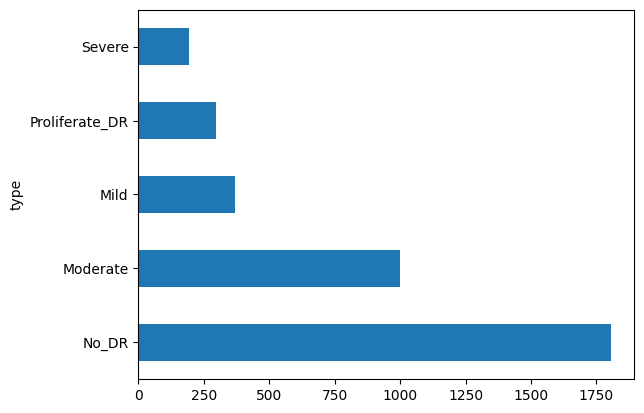

In [6]:
df['type'].value_counts().plot(kind='barh')

In [7]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print("For Training Dataset :")
print(train['type'].value_counts(), '\n')
print("For Testing Dataset :")
print(test['type'].value_counts(), '\n')
print("For Validation Dataset :")
print(val['type'].value_counts(), '\n')

For Training Dataset :
type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

For Testing Dataset :
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

For Validation Dataset :
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [8]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [10]:
from tqdm import tqdm
import os, shutil

src_dir = '/content/drive/MyDrive/archive/colored_images'

for index, row in tqdm(train.iterrows(), total=len(train), desc="Copying training images"):
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"

    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfolder = os.path.join(train_dir, binary_diagnosis)
    dstfile = os.path.join(dstfolder, id_code)

    os.makedirs(dstfolder, exist_ok=True)

    if not os.path.exists(dstfile):
        shutil.copy2(srcfile, dstfile)


for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

Copying training images: 100%|██████████| 2562/2562 [12:59<00:00,  3.28it/s]


In [12]:
train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [15]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=100,
                    validation_data=val_batches)
model.save("Finished_Model.h5")

ValueError: Argument(s) not recognized: {'lr': 1e-05}

In [11]:
model.save('model_weights.h5')

NameError: name 'model' is not defined

In [ ]:
# Load the model from the .h5 file
#loaded_model = tf.keras.models.load_model('path/to/model.h5')
# Load the model from the .h5 file
loaded_model = tf.keras.models.load_model('/content/Finished_Model.h5')

# Assuming you have a TensorFlow model named 'model'
#model_json = model.to_json()

# Save the model architecture in JSON format
#with open("model.json", "w") as json_file:
    #json_file.write(model_json)

#weights = [np.array(w) for w in model.get_weights()]

# Save weights to a binary file
#with open("model_weights.bin", "wb") as binary_file:
    #for weight in weights:
        #binary_file.write(weight.tobytes())

In [ ]:
# Load Json
# Load the model architecture from the JSON file
##with open("model.json", "r") as json_file:
    #loaded_model_json = json_file.read()
# Load the model from the HDF5 file
loaded_model = tf.keras.models.load_model("Finished_Model.h5")

# Check the loaded model summary
loaded_model.summary()
#loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# Load the weights into the model

with open("model_weights.h5", "rb") as bin_file:
    for layer in loaded_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            # For BatchNormalization layers, load gamma and beta
            gamma_beta = np.fromfile(bin_file, dtype=np.float32, count=2 * layer.input_shape[-1])
            gamma = gamma_beta[:layer.input_shape[-1]]
            beta = gamma_beta[layer.input_shape[-1]:]
            moving_mean = np.fromfile(bin_file, dtype=np.float32, count=layer.input_shape[-1])
            moving_variance = np.fromfile(bin_file, dtype=np.float32, count=layer.input_shape[-1])

            layer.set_weights([gamma, beta, moving_mean, moving_variance])
        else:
            # For other layers, load weights as usual
            layer_weights = [np.fromfile(bin_file, dtype=np.float32, count=np.prod(param.shape)).reshape(param.shape)
                             for param in layer.trainable_variables]
            layer.set_weights(layer_weights)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 8)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 8)       32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                        

In [ ]:
import tensorflow as tf

# Load the model from HDF5 file
loaded_model = tf.keras.models.load_model("hist2.h5")

# Check the loaded model summary
loaded_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 8)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 8)       32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                        

In [ ]:
# Load the weights into the model
with open("model_weights.h5", "rb") as bin_file:
    for layer in loaded_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            # For BatchNormalization layers, load gamma and beta
            gamma_beta = np.fromfile(bin_file, dtype=np.float32, count=2 * layer.input_shape[-1])
            gamma = gamma_beta[:layer.input_shape[-1]]
            beta = gamma_beta[layer.input_shape[-1]:]
            moving_mean = np.fromfile(bin_file, dtype=np.float32, count=layer.input_shape[-1])
            moving_variance = np.fromfile(bin_file, dtype=np.float32, count=layer.input_shape[-1])

            layer.set_weights([gamma, beta, moving_mean, moving_variance])
        else:
            # For other layers, load weights as usual
            layer_weights = [np.fromfile(bin_file, dtype=np.float32, count=np.prod(param.shape)).reshape(param.shape)
                             for param in layer.trainable_variables]
            layer.set_weights(layer_weights)



In [ ]:
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
print("Original: -\n")
loss, acc = model.evaluate_generator(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)
print("Loaded: -\n")
loss, acc = loaded_model.evaluate_generator(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

<ipython-input-22-22bcb8ce5649>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


Original: -

18/18 [==============================] - 2s 90ms/step - loss: 0.3482 - acc: 0.9473
Loss:  0.34822559356689453
Accuracy:  0.9472727179527283
Loaded: -



<ipython-input-22-22bcb8ce5649>:9: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = loaded_model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 2s 75ms/step - loss: nan - acc: 0.5073
Loss:  nan
Accuracy:  0.5072727203369141


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
#     new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=loaded_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('Diabetic Retinopathy Not Detected')
    else:
        print('Diabetic Retinopathy Detected')

KeyboardInterrupt: 